# No difference with 1_TCNs_for_train.ipynb  
- Just dataset (folder) reading part is changed

In [1]:
import os
import numpy as np 
import time
from sklearn.model_selection import KFold  # 라벨 x_data, y_data 분포를 유지 (함께 fold)
from IPython.display import clear_output
import matplotlib.pyplot as plt

homeDir = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel"
os.chdir(homeDir); print(" [Home Dir.] Current path", os.getcwd())  

from TCN_v1_Lib.preprocessing import preprocess
from TCN_v1_Lib.plot_graph import plotGragh

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현

 [Home Dir.] Current path /DockerProjects/walkCAM/tug/temporalCNN_wLabel


In [2]:
#---- Param Selection-----#
lpf_order = 4
cut_off = 3.5
selected_LPF = "c{0}o{1}".format(cut_off,lpf_order).replace(".","-")
print(" --------- Seleced Type: LPF (4th) Cutoff ",cut_off,"Hz")

selected_type = 'norm60' # stroke -3 ,  norm60 -22,  norm20 -1
mean_datalist = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/{selected_LPF}/{selected_LPF}_mean_{selected_type}.csv".format(selected_LPF=selected_LPF, selected_type=selected_type)
print("selected_type: ", selected_type, "\n --> File Path: ", mean_datalist )


class_weight_1 = {0:0.303, 1:1.0, 2: 0.144, 3:0.487, 4: 0.7} #
class_weight_2 = {0:1.3 , 1:4.5, 2: 1.0 ,  3: 1.6, 4: 4.5} # 
class_weight_3 = {0:0.112 , 1:0.365, 2: 0.046 ,  3: 0.184, 4: 0.293} # sum = 1  
class_weight = class_weight_1

cw_type = None

if class_weight == class_weight_1:
    cw_type = "class_weight_1"
elif class_weight == class_weight_2:
    cw_type = "class_weight_2"
elif class_weight == class_weight_3:
    cw_type = "class_weight_3"
    
    
#----- model Param
batch_size = 512  # 512 fixed 
epochs = 100000

patience = 50
learning_rate = 0.00007

 --------- Seleced Type: LPF (4th) Cutoff  3.5 Hz
selected_type:  norm60 
 --> File Path:  /DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/c3-5o4/c3-5o4_mean_norm60.csv


In [3]:
rootDir = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel" 
expertFolder = "/" + "HMM_saveResults_illness_mean"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 


utils = preprocess(datasetDir, expertFolder)
plot = plotGragh(actSplit=True, save=False)

 Current workaing path [dataset]  /DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/HMM_saveResults_illness_mean/0_sideView


## Create Dataset 
#### - Choose specific group (norm 20, norm60, stroke... or K-fold)

In [4]:
train_ratio = 0.6
valid_ratio = 0.2

shuffle = True
arbitrarySplit = True
Kfold = False
Kfold_num = 5 

subjects = np.loadtxt(mean_datalist, delimiter=",", skiprows=1, usecols=0, dtype=str)
specific_group = sorted(set(subjects))  # - remove duplicated trials 
numOfsubjects = len(specific_group)
print("# of Subjects: ",numOfsubjects, "\n", specific_group)

if Kfold:

    print(" K-fold : ", Kfold_num)
    trainFold, testFold = utils.fold_trainNames(subList = specific_group, Kfold_num = Kfold_num)
        
else:
    np.random.shuffle(specific_group)
    
    trainSub_number = np.round( (numOfsubjects*train_ratio), 0).astype(int)
    validSub_number = np.round( (numOfsubjects*valid_ratio), 0).astype(int)
    testSub_number = numOfsubjects - trainSub_number - validSub_number

    train_subjects = specific_group[ :trainSub_number]
    valid_subjects = specific_group[ trainSub_number : (trainSub_number + validSub_number)]
    test_subjects = specific_group[ (trainSub_number+validSub_number): ]
    
    print(" No-fold --- (arbitrary) \t [results] \n\t Train 명: " ,len(train_subjects), "\n\t Valid 명: ", len(valid_subjects), "\n\t Test 명: ", len(test_subjects))
    print(" No-fold --- (arbitrary) \t [results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)
    

# of Subjects:  23 
 ['BKS_TUG', 'CSY_TUG', 'GYH_TUG', 'HOJ_TUG', 'HSN_TUG', 'JJS_TUG', 'KBH_TUG', 'KHM_TUG', 'KJK_TUG', 'LBL_TUG', 'LJE_TUG', 'LJS_TUG', 'LKO_TUG', 'LSC_TUG', 'LSJ_TUG', 'LSS_TUG', 'NHJ_60', 'PBK_TUG', 'PSM_TUG', 'SJJ_TUG', 'SOS_TUG', 'UMS_TUG', 'rjh']
 No-fold --- (arbitrary) 	 [results] 
	 Train 명:  14 
	 Valid 명:  5 
	 Test 명:  4
 No-fold --- (arbitrary) 	 [results] 
	 Train:  ['CSY_TUG', 'JJS_TUG', 'GYH_TUG', 'rjh', 'SOS_TUG', 'LKO_TUG', 'LJS_TUG', 'BKS_TUG', 'UMS_TUG', 'KBH_TUG', 'PSM_TUG', 'NHJ_60', 'LSC_TUG', 'LJE_TUG'] 
	 Valid:  ['PBK_TUG', 'LBL_TUG', 'KJK_TUG', 'LSJ_TUG', 'KHM_TUG'] 
	 Test:  ['SJJ_TUG', 'HOJ_TUG', 'HSN_TUG', 'LSS_TUG']


In [5]:
utils.lookback_window = 8

Foldername = "Originact5_lpf_" + selected_LPF
print(Foldername)
# total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  utils.readRaw_createDataset(specific_group, train_subjects, test_subjects, lookback_window = lookback_window)
total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  utils.readLPF_createDataset(specific_group, train_subjects, test_subjects, Foldername, Kfold)
print("train_x: ", train_x.shape," , train_y: ", train_y.shape)
print("valid_x: ",valid_x.shape, " , valid_y: ",valid_y.shape)
print("test_x: ",test_x.shape, "  , test_y: ",test_y.shape)

Originact5_lpf_c3-5o4
train_x:  (54962, 8, 3, 1)  , train_y:  (54962, 5)
valid_x:  (19825, 8, 3, 1)  , valid_y:  (19825, 5)
test_x:  (16822, 8, 3, 1)   , test_y:  (16822, 5)


### Model Build

In [6]:
import tensorflow as tf
from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tcn import TCN

In [7]:
 #Residual block :: https://roadcom.tistory.com/95
def ResBlock(x,filters,kernel_size,dilation_rate):
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate,activation='relu')(x) #first convolution
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate)(r) #Second convolution
    if x.shape[-1]==filters:
        # Shortcut 의 channel 과 main path 의 channel 이 일치할 경우 단순 add 연산만 진행하는 블록 = identity block
        shortcut = x  # identity block 
    else: 
        # Shortcut 의 channel 과 main path 의 channel 이 다를 경우 shortcut path 를 적절히 변환
        # 즉, projection 을 통해 channel 을 맞춰주는 작업이(projection shortcut) 추가되기에 이를 convolution block 이라함
        shortcut=Conv2D(filters,kernel_size=kernel_size,padding='same')(x) 
    o=add([r,shortcut])
    o=Activation('relu')(o) 
    return o
 
 #Sequence Model
def TCN(optimizer='adam'):
    kernel_size = (3,3)
    input_shape =  (utils.lookback_window, 3, 1) # (8,3, 1) = (feature, sliding_window, 1)
    
    inputs=Input(shape=input_shape)
    
    x=ResBlock(x = inputs,filters=32,kernel_size=kernel_size,dilation_rate=1)
#     BatchNormalization()
    x = Dropout(0.2) (x)
    x=ResBlock(x,filters=32,kernel_size=kernel_size,dilation_rate=2)
#     BatchNormalization()
    x = Dropout(0.4)(x)
    
    x=ResBlock(x,filters=16,kernel_size=kernel_size,dilation_rate=4)
    
    x=Flatten()(x)
    x=Dense(utils.numActions, activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
         
    model.summary()
        
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
 
    return model

In [8]:
ModelTime =  time.strftime('%Y%m%d-%Hh%Mm', time.localtime(time.time()))
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" + selected_LPF + expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience) + "-lr:"+ str(learning_rate) + "_" + ModelTime +  "/Model" 


print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.makedirs(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "-Batch"+ str(batch_size) +"-lr:"+ str(learning_rate) +"-p:" +str(patience)+ "_{epoch:04d} -- {val_loss:.4f}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="val_loss", patience=patience)

/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/c3-5o4/HMM_saveResults_illness_mean/class_weight_1/norm60_P50-lr:7e-05_20210521-15h11m/Model


In [9]:

optimizer = tf.optimizers.Adam(learning_rate)

model = TCN(optimizer)
model.save(MODEL_SAVE_FOLDER_PATH+"/Origin_TCN_model")
hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=2, validation_data= (valid_x, valid_y),   callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
eval_result = model.evaluate(test_x, test_y,batch_size= batch_size,verbose=2)

print('test_loss:',eval_result[0],'- test_acc:',eval_result[1])

reportd_subjects = open(MODEL_SAVE_FOLDER_PATH + "/" + str(selected_type)+ "_subjectLists" ".txt",'w+t')
    

print("[Train subjects]\n\t", train_subjects , file =reportd_subjects )
print("[Valid subjects]\n\t", valid_subjects , file =reportd_subjects )
print("[Test subjects]\n\t", test_subjects , file =reportd_subjects )
print("======== Class Weight =========", file =reportd_subjects)
print("\t --> sit,   sit-stand,   walk,   turn,   stand-sit ",class_weight, file =reportd_subjects)
print('test_loss:',eval_result[0],'- test_acc:',eval_result[1], file =reportd_subjects)
reportd_subjects.close()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 3, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 3, 32)     320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 3, 32)     9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 3, 32)     320         input_1[0][0]                    
______________________________________________________________________________________________

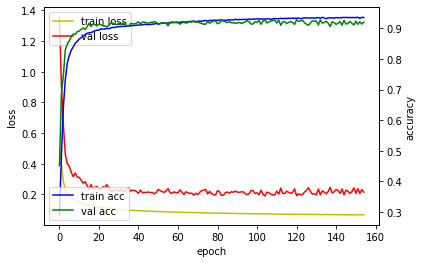

In [10]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.savefig(MODEL_SAVE_FOLDER_PATH+"/lr_"+str(learning_rate)+"_patience_"+ str(patience)+"_Loss_"+str(np.round(eval_result[1],4))+".png")
plt.show()


In [11]:
def action_frames(y_pred_argmax, ratio_display = False):
    action_label =  {"sit": 0, "sit-stand": 1,  "walk": 2, "turn": 3,  "stand-sit": 4}
    action_cnt =  {"total_frames": 0,"sit": 0, "sit-stand": 0,  "walk": 0, "turn": 0,"stand-sit": 0}

    for i in range(len(y_pred_argmax)):
        action_cnt["total_frames"] +=1
        if y_pred_argmax[i] == action_label["sit"]:
            action_cnt["sit"] +=1
            
        elif y_pred_argmax[i] == action_label["sit-stand"]:
            action_cnt["sit-stand"] +=1
            
        elif y_pred_argmax[i] == action_label["walk"]:
            action_cnt["walk"] +=1
            
        elif y_pred_argmax[i] == action_label["turn"]:
            action_cnt["turn"] +=1
        
            
        elif y_pred_argmax[i] == action_label["stand-sit"]:
            action_cnt["stand-sit"] +=1
        
    if ratio_display:     
        print("[ Action Ratio ]")
        print("\t [ 0 - Sit] ratio of sit: ",  action_cnt["sit"]/action_cnt["total_frames"] )
        print("\t [ 1 - sit-stand] ratio of sit-stand: ",  action_cnt["sit-stand"]/action_cnt["total_frames"])
        print("\t [ 2 - walk] ratio of walk: ",  action_cnt["walk"]/action_cnt["total_frames"])
        print("\t [ 3 - turn] ratio of turn: ",  action_cnt["turn"]/action_cnt["total_frames"])
        print("\t [ 4 - stand-sit] ratio of stand-sit: ",  action_cnt["stand-sit"]/action_cnt["total_frames"])
    return action_cnt
    
    
    
y_pred = model.predict(test_x)
y_pred_onehot = np.argmax(y_pred, axis=1)
print(y_pred.shape)
print(y_pred[200] ,"===> onehot: ", y_pred_onehot[200])

y_test_argmax = np.argmax(test_y ,axis=1) 
y_pred_argmax = np.argmax(y_pred ,axis=1)
print(y_test_argmax.shape, y_pred_argmax.shape)


y_pred_frames = action_frames(y_pred_argmax, ratio_display= True)
y_test_frames = action_frames(y_test_argmax,  ratio_display= True)   

print("--->  # of Each Action Frames  \n\t y_pred: {0}, \n\t y_test: {1}".format(y_pred_frames, y_test_frames))

(16822, 5)
[0.     0.     0.9972 0.0028 0.    ] ===> onehot:  2
(16822,) (16822,)
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.2904529782427773
	 [ 1 - sit-stand] ratio of sit-stand:  0.06687670907145404
	 [ 2 - walk] ratio of walk:  0.4273570324574961
	 [ 3 - turn] ratio of turn:  0.13666627036024254
	 [ 4 - stand-sit] ratio of stand-sit:  0.07864700986802996
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.2904529782427773
	 [ 1 - sit-stand] ratio of sit-stand:  0.059505409582689336
	 [ 2 - walk] ratio of walk:  0.4403756984900725
	 [ 3 - turn] ratio of turn:  0.12786826774462015
	 [ 4 - stand-sit] ratio of stand-sit:  0.08179764593984068
--->  # of Each Action Frames  
	 y_pred: {'total_frames': 16822, 'sit': 4886, 'sit-stand': 1125, 'walk': 7189, 'turn': 2299, 'stand-sit': 1323}, 
	 y_test: {'total_frames': 16822, 'sit': 4886, 'sit-stand': 1001, 'walk': 7408, 'turn': 2151, 'stand-sit': 1376}


Cohens kappa: 0.910349
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4886
           1       0.80      0.90      0.85      1001
           2       0.96      0.94      0.95      7408
           3       0.90      0.96      0.93      2151
           4       0.85      0.82      0.84      1376

    accuracy                           0.94     16822
   macro avg       0.90      0.92      0.91     16822
weighted avg       0.94      0.94      0.94     16822


---> Confusion Matrix 
 [[4729  115    0    0   42]
 [  94  905    0    0    2]
 [   0   99 6932  229  148]
 [   0    0   81 2070    0]
 [  63    6  176    0 1131]]


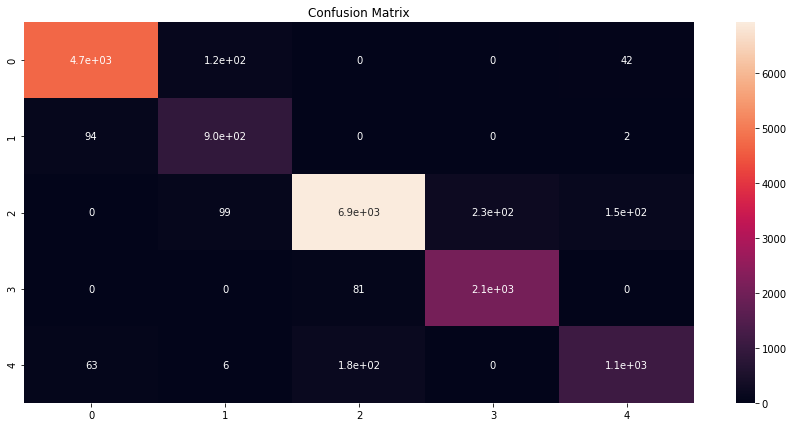

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


kappa = cohen_kappa_score(y_test_argmax, y_pred_argmax)
print('Cohens kappa: %f' % kappa)

print(classification_report(y_test_argmax, y_pred_argmax))
conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
print("\n---> Confusion Matrix \n" ,conf_matrix) # sit, sit-stand, walking, turning, stand-sit

plt.figure(figsize = (15,7) )
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.savefig(MODEL_SAVE_FOLDER_PATH+"/pred_Confusion_Matrix.png")
plt.show()

# os.rename(MODEL_SAVE_FOLDER_PATH, MODEL_SAVE_FOLDER_PATH + "_loss-" + str(np.round(eval_result[1],4)))
src ="/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" + selected_LPF + expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience) + "-lr:"+ str(learning_rate) + "_" + ModelTime 
dst = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" + selected_LPF +  expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience) + "-lr:"+ str(learning_rate) +"_" + ModelTime + "_loss-" + str(np.round(eval_result[1],4))
print(dst)
os.rename(src, dst)

## POST processing (DTW) 

In [13]:
from dtw import dtw
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


act_dict = {"sit":0, "sit-to-stand":1, "walk": 2, "turn": 3, "stand-to-sit":4}
answer_y = [act_dict["sit"], act_dict["sit-to-stand"], act_dict["walk"], act_dict["turn"], act_dict["walk"], act_dict["stand-to-sit"], act_dict["sit"] ]
target_names = ["sit", "sit-to-stand", "walk", "turn", "stand-to-sit"]

def create_testdata(pelvis_csv):
    test_x = np.zeros((0, utils.lookback_window, utils.numPelvis,1 ))
    test_y = np.zeros((0, utils.numActions)) 
   
    timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  = utils.getLPF_PelvisData(pelvis_csv)  # raw                 
    pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
    actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
    blockTime, blockPelvis, blockLable = utils.sliding_window(timstamp_ms, data_x = pelvisData, data_y = actionData)
    test_x = np.append(test_x, blockPelvis, axis = 0 )
    test_y = np.append(test_y, blockLable, axis = 0 )    
    
    return blockTime, test_x, test_y


def plot_postResults(answer_y, pred_y, results, saveDir , title="subname"):
    fig = plt.figure(figsize=(20,15))
    
    Gnd_fig = fig.add_subplot(2,3,1)
    Gnd_fig.set_title(" Ground Truth ")
    Gnd_fig.plot(answer_y, "g", label = "Ground Truth")
    plt.legend()
    
    pred_fig = fig.add_subplot(2,3,2)
    pred_fig.set_title(" Prediction Result (Before DTW) ")
    pred_fig.plot(pred_y, "b", label=" pred_y (before DTW)")
    plt.legend()
    
    dtw_fig = fig.add_subplot(2,3,3)
    dtw_fig.set_title(" PostProcessing Results (DTW) ")
    dtw_fig.plot(results, "r",  label="dtw_result")
    plt.legend()
    
    gnd_pred_fig = fig.add_subplot(2,3,4)
    gnd_pred_fig.set_title(" Comparison: Ground Truth vs Prediction")
    gnd_pred_fig.plot(answer_y, "g", label="Ground Truth") # linewidth=3
    gnd_pred_fig.plot(pred_y, "b--", label=" pred_y (before DTW)")
    plt.legend()
    
    pred_dtw_fig = fig.add_subplot(2,3,5)
    pred_dtw_fig.set_title(" Comparison: Prediction vs DTW alignment")
    pred_dtw_fig.plot(pred_y, "b--", label=" pred_y (before DTW)") # linewidth=3
    pred_dtw_fig.plot(results, "r", label=" dtw_result")
    plt.legend()
    
    gnd_dtw_fig = fig.add_subplot(2,3,6)
    gnd_dtw_fig.set_title(" Comparison: Ground Truth vs DTW alignment ")
    gnd_dtw_fig.plot(answer_y, "g--", label="Ground Truth")
    gnd_dtw_fig.plot(results, "r", label="dtw_result")  # linewidth=3
    
    plt.legend()
    plt.savefig(saveDir+"/2_DTW_Comparison_" + title  + ".png")
    
    
def saveDTW_plt(test_y, pred_y, dtw_results,  saveDir , title = "title"):
    plot_postResults(test_y, pred_y, dtw_results,  saveDir, title) 
    report_dtw = open(saveDir + "/2_Comp_DTW_" + title + ".txt",'w+t')
    print("[Before DTW] \n", classification_report(test_y, pred_y, target_names=target_names), file=report_dtw)
    print("------------------------------\n", file = report_dtw)
    print("[After DTW] \n", classification_report(test_y, dtw_results, target_names=target_names), file = report_dtw)
    report_dtw.close()
    

def barplot_splitResults(pred_subTask_frame, true_subTask_frame, pred_totalTime, true_totalTime, saveDir, title="title"):
    subTask_label = ['sit-to-stand', 'walk', 'turn', 'walk-back', 'sit-back']
    actIndex = np.arange(len( ["Pred", "Truth"]))
    color = ['b','g','r','c','y']
    
        
    fig = plt.figure(figsize=(12,4))
    plt.title('TUG sub-Task segmentation Results\n', loc='center')
    plt.xlabel('frames')
    plt.yticks(actIndex,  ["Model Pred", "Ground Truth"])
    plt.text(10, 0.5, "True totalTime: " + str(np.round(true_totalTime,4)) + "  ,   Pred totalTime: " + str(np.round(pred_totalTime,4)), fontsize=13)
    plt.text(10,-0.8, "TotalTime Error (sec): " + str(np.round(np.abs(true_totalTime-pred_totalTime),4)), fontsize=13, fontweight='bold')
    
    for i in range(len(color)):
        rects = plt.barh(actIndex,  [pred_subTask_frame[i] , true_subTask_frame[i]] , color = color[i], left = [ np.sum(np.sum(pred_subTask_frame[:i])),  np.sum(np.sum(true_subTask_frame[:i]))] )
 
        for j, rect in enumerate(rects):
            if j is 0:  # --- pred
                h1 = rect.get_height()
                w1 = rect.get_width()
                plt.text(rect.get_x() + rect.get_width() / 2., h1 / 1., "%d" % true_subTask_frame[i], color="k", fontsize=12, fontweight="bold")         

            else:  # -- true 
                h2 = rect.get_height()
                w2 = rect.get_width()
                plt.text(rect.get_x() + w2/ 2., (h2-h1) / 1.,"%d" % pred_subTask_frame[i], color="k", fontsize=12, fontweight="bold")

    plt.legend(subTask_label,  bbox_to_anchor=([1, 1, 0, 0]))                         
    plt.savefig(saveDir+"/2_BarGragh_FrameSplit_" + title  + ".png")
    

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [14]:
def post_process_DTW(test_y, pred_y, answer_y):
    dtw_index ={"walk":4, "stand-to-sit": 5, "sit": 6}
    dtw_alignment  = dtw(pred_y,answer_y, keep_internals=True)
    
    # ------------ Index 4,5,6 --> 2,4,0 으로 변경 
    results =[]
    for elements in dtw_alignment.index2:
        if elements == dtw_index["walk"]: 
            elements = act_dict["walk"]
        elif elements == dtw_index["stand-to-sit"]:  
            elements = act_dict["stand-to-sit"]
        elif elements == dtw_index["sit"]:  
            elements =  act_dict["sit"]     
        results.append(elements)

    # 간혹.. dtw 결과가 1개 더 많이 나올 때 있음.. 걍 뒤에 하나 지워버려..
    pred_maxlen = len(pred_y)
    new_result = results[:pred_maxlen]
    new_result[-1] = results[-1]
    
    return dtw_alignment, new_result


def calc_accuracy(test_y, pred_y, dtw_results, saveDir, title="title", save=False):
    pred_acc = np.round( np.mean(np.equal(test_y , pred_y)), 6) *100
    dtw_acc = np.round( np.mean(np.equal(test_y , dtw_results)), 6) *100
    
    if pred_acc < dtw_acc:
        accComptxt = open(saveDir + "/1_acc_Improved_" + title  +".txt", 'w+t')
        print("[before dtw] Model Pred Acc: ", pred_acc, "[%]\n[After dtw] Final Classification Acc: ",dtw_acc,"[%]", file=accComptxt)
        print("[After - Before acc] Final Classification Acc - Model Pred Acc: \n\t", dtw_acc-pred_acc, file = accComptxt)
        accComptxt.close()
    
    if save:
        x_label = ['Model_pred', 'DTW_Final_Results']
        y_value = [pred_acc, dtw_acc]
        color = ['b','r']

        fig = plt.figure(figsize=(5,5))
        plt.title(title +": Accuracy Comparison", loc='center')
        plt.bar(x_label, y_value, color=color, width=0.6)
        
        for i, v in enumerate(x_label):
            plt.text(v, y_value[i], y_value[i], fontsize=9,horizontalalignment='center', verticalalignment='bottom')
        plt.savefig(saveDir +"/1_accComp_" + title  + ".png")
        plt.close()

    return pred_acc , dtw_acc 


    

def analysis_timeResults(test_time, test_x, test_y, pelvis_x, pelvis_y, pelvis_z, dtw_reesult, saveDir, title = "title", save=False):
    true_subTask_sec = np.zeros(5)
    dtw_subTask_sec = np.zeros(5)
    
    true_subTask_frame = np.zeros(5, np.uint64)
    dtw_subTask_frame = np.zeros(5, np.uint64)

    true_splitFrame = np.where( np.abs(test_y[1:]-test_y[:-1] ) > 0)[0] + utils.lookback_window  # lookback_window
    dtw_splitFrame = np.where( np.abs(dtw_reesult[1:]-dtw_reesult[:-1] ) > 0)[0] + utils.lookback_window # lookback_window   
    exceptTrial_check = False
    
    true_maxlen = len(test_y)
    dtw_maxlen = len(dtw_reesult)
    
    if len(dtw_splitFrame) !=6  or dtw_maxlen < dtw_splitFrame[5]:
        exceptTrial_check = True
        report_failed = open(saveDir+"/1_Pred_DTW_Failed_Case_"+ str(title) + ".txt", "w+t" )
        print("Action states are predicted less or more (should 6) \n\t{0}".format(len(dtw_splitFrame)), file=report_failed)
        print("Current Subjects + Trial : \n\t{0}".format(title) , report_failed)
        report_failed.close()
        pass
        true_dtw_total_Error_percent = 0 
        true_dtw_subTask_Error_percent =0 
        return true_dtw_total_Error_percent, true_dtw_subTask_Error_percent ,exceptTrial_check 

    else:
         #------------------ Frame related File
        report_Frame= open(saveDir + "/3_1_Results_Frame_" + str(title)  +".txt",'w+t')
        print("\nTrue splitFrame: \n\t{0} \nDTW splitFrame : \n\t{1}".format(true_splitFrame, dtw_splitFrame), file = report_Frame)

        for i in range(utils.numActions):
            true_subTask_sec[i] = np.round(test_time[ true_splitFrame[i+1]] - test_time[ true_splitFrame[i]],4)    
            dtw_subTask_sec[i] = np.round(test_time[ dtw_splitFrame[i+1]] - test_time[ dtw_splitFrame[i]],4)  # sit ~ sit-to-stand (sit-to-stand)

            true_subTask_frame[i] = np.round(true_splitFrame[i+1] - true_splitFrame[i],4)
            dtw_subTask_frame[i] = np.round(dtw_splitFrame[i+1] - dtw_splitFrame[i],4)

        print("\nTrue subTask Consuming frame: \n\t{0} \nDTW subTask Consuming frame : \n\t{1}".format(true_subTask_frame, dtw_subTask_frame), file = report_Frame)
        report_Frame.close()

        #------------------ Time related File
        report_time= open(saveDir + "/3_2_Results_Time_" + str(title)  +".txt",'w+t')
        print("\nTrue subTask Consuming Time: \n\t{0} \nDTW subTask Consuming sec : \n\t{1}".format(true_subTask_sec,dtw_subTask_sec), file = report_time)

         # ---- Total Time
        true_totalTime = np.round(np.sum(true_subTask_sec),4)
        dtw_totalTime = np.round(np.sum(dtw_subTask_sec),4)  
        print("\nTrue Total ConsumingTime: \n\t{0} \nDTW Total Consuming Time: \n\t{1}".format(true_totalTime, dtw_totalTime), file = report_time)

        #----------- Error---------
        true_dtw_subTask_Error = np.abs(np.round(true_subTask_sec - dtw_subTask_sec,4))
        true_dtw_subTask_Error_percent = true_dtw_subTask_Error/true_totalTime
        print("\n[SubTask Time Error] DTW - True (sec,%):\n\t{0}".format(true_dtw_subTask_Error), file = report_time)
        print("\n[SubTask Time Error/totalTime] DTW - True (%):\n\t{0}".format(true_dtw_subTask_Error_percent), file = report_time)

        true_dtw_total_Error = np.abs(np.round(true_totalTime - dtw_totalTime,4))   
        true_dtw_total_Error_percent = true_dtw_total_Error/true_totalTime
        print("\n[Total Time Error] DTW - True (sec,%):\n\t{0}".format(true_dtw_total_Error), file = report_time)    
        print("\n[Total Time Error/totalTime] DTW - True (%):\n\t{0}".format(true_dtw_total_Error_percent), file = report_time)
        report_time.close()

        #-----Save Gait Features
        sitStand_timeIdx = 0
        standSit_timeIdx = 4
        walk_timeIdx = [1,3]
        turn_timeIdx = 2

        # -----Save Tie related Features and Error 
        report_taskTime= open(saveDir + "/0_1_Extract_taskTime_" + str(title)  +".txt",'w+t')
        print("[DTW total Time]: \n\t{0}".format(dtw_totalTime), file = report_taskTime)
        print("[DTW Task Time]: \n\t{0}".format(dtw_subTask_sec), file = report_taskTime)
        print("---------- Task Time/Speed ------------", file = report_taskTime)
        print("[DTW sit-stand Time]: \n\t{0}".format(dtw_subTask_sec[sitStand_timeIdx]), file = report_taskTime)
        print("[DTW stand-sit Time]: \n\t{0}".format(dtw_subTask_sec[standSit_timeIdx]), file = report_taskTime)
        print("[DTW Walk Time]: \n\t{0}".format(dtw_subTask_sec[walk_timeIdx]), file = report_taskTime)
        print("[DTW Turn Time]: \n\t{0}".format(dtw_subTask_sec[turn_timeIdx]), file = report_taskTime)

        print("\n---------- Time Error  (sec) ------------", file = report_taskTime)
        print("[Error sit-stand Time]: \n\t{0}".format(true_dtw_subTask_Error[sitStand_timeIdx]), file = report_taskTime)
        print("[Error stand-sit Time]: \n\t{0}".format(true_dtw_subTask_Error[standSit_timeIdx]), file = report_taskTime)
        print("[Error Walk Time]: \n\t{0}".format(true_dtw_subTask_Error[walk_timeIdx]), file = report_taskTime)
        print("[Error Turn Time]: \n\t{0}".format(true_dtw_subTask_Error[turn_timeIdx]), file = report_taskTime)

        print("\n---------- % Error /true total Time (%) ------------", file = report_taskTime)
        print("[Error sit-stand %]: \n\t{0}".format(true_dtw_subTask_Error[sitStand_timeIdx]/true_totalTime), file = report_taskTime)
        print("[Error stand-sit %]: \n\t{0}".format(true_dtw_subTask_Error[standSit_timeIdx]/true_totalTime), file = report_taskTime)
        print("[Error Walk %]: \n\t{0}".format(true_dtw_subTask_Error[walk_timeIdx]/true_totalTime), file = report_taskTime)
        print("[Error Turn %]: \n\t{0}".format(true_dtw_subTask_Error[turn_timeIdx]/true_totalTime), file = report_taskTime)    
        report_taskTime.close()

        # ----- Cacl And Save Speed
        # 1-1. startWalk part frame + time 
        true_startWalk_Frame = true_splitFrame[1]
        dtw_startWalk_Frame = dtw_splitFrame[1]
        true_sitStand_startTime = test_time[true_startWalk_Frame]
        dtw_sitStand_startTime = test_time[dtw_startWalk_Frame]
        
        report_gaitParam= open(saveDir + "/0_2_Extract_gaitParams" + str(title)  +".txt",'w+t')
        true_sitStand_position = np.array([pelvis_x[true_startWalk_Frame+(utils.lookback_window-1)],pelvis_y[true_startWalk_Frame+(utils.lookback_window-1)],pelvis_z[true_startWalk_Frame+(utils.lookback_window-1)]])
        dtw_sitStand_position = np.array([pelvis_x[dtw_startWalk_Frame+(utils.lookback_window-1)],pelvis_y[dtw_startWalk_Frame+(utils.lookback_window-1)],pelvis_z[dtw_startWalk_Frame+(utils.lookback_window-1)]])
        
        print("\n[True -> sitStand] startWalk frame: \n\t{0}  \n startWalk Time: \n\t{1} ".format(true_startWalk_Frame, true_sitStand_startTime) , file = report_gaitParam)
        print("[True -> sitStand] startWalk Pelvis [X,Y,Z]: \n\t{0}   ".format(true_sitStand_position), file = report_gaitParam)
        print("\n[DTW -> sitStand] startWalk frame: \n\t{0}  \n startWalk Time: \n\t{1} ".format(dtw_startWalk_Frame, dtw_sitStand_startTime), file = report_gaitParam)
        print("[DTW -> sitStand] startWalk Pelvis [X,Y,Z]: \n\t{0}  \n ".format(dtw_sitStand_position), file = report_gaitParam)
        
        # 1-2. starTrun part frame + time 
        true_starTrun_frame = true_splitFrame[2]
        dtw_starTrun_frame = dtw_splitFrame[2]
        true_starTrun_startTime = test_time[true_starTrun_frame]
        dtw_starTrun_startTime = test_time[dtw_starTrun_frame]   
        
        true_starTrun_position = np.array([pelvis_x[true_starTrun_frame+(utils.lookback_window-1)],pelvis_y[true_starTrun_frame+(utils.lookback_window-1)],pelvis_z[true_starTrun_frame+(utils.lookback_window-1)]])
        dtw_starTrun_position = np.array([pelvis_x[dtw_starTrun_frame+(utils.lookback_window-1)],pelvis_y[dtw_starTrun_frame+(utils.lookback_window-1)],pelvis_z[dtw_starTrun_frame+(utils.lookback_window-1)]])
 
        print("\n[True -> starTrun] starTrun frame: \n\t{0}  \n starTrun Time: \n\t{1} ".format(true_starTrun_frame, true_starTrun_startTime), file = report_gaitParam)
        print("[True -> starTrun] starTrun Pelvis [X,Y,Z]: \n\t{0}   ".format(true_starTrun_position), file = report_gaitParam)
        print("\n[DTW -> starTrun] starTrun frame: \n\t{0}  \n starTrun Time: \n\t{1} ".format(dtw_starTrun_frame, dtw_starTrun_startTime) , file = report_gaitParam)
        print("[DTW -> starTrun] starTrun Pelvis [X,Y,Z]: \n\t{0}   ".format(dtw_starTrun_position) , file = report_gaitParam)
      
    
        #----------1-1 + 1-2 --> walking distance & time 
        # Block 된 data --> 다음과 같이 matching 됨 test_time[0], test_x[0,-1] (8개중 마지막 data) , test_y[0]

        true_walk_distance = np.linalg.norm(true_starTrun_position - true_sitStand_position)  # unit [m]
        dtw_walk_distance = np.linalg.norm(dtw_starTrun_position - dtw_sitStand_position)
        
        true_walk_time = true_starTrun_startTime -  true_sitStand_startTime  # unit [sec]
        dtw_walk_time = dtw_starTrun_startTime -  dtw_sitStand_startTime 
        
        true_walk_speed = np.round(true_walk_distance /true_walk_time,5)  # units ==> [m/s]
        dtw_walk_speed = np.round(dtw_walk_distance /dtw_walk_time,5)
        
        walk_dist_error = np.abs(true_walk_distance - dtw_walk_distance)
        walk_time_error =  np.abs(true_walk_time - dtw_walk_time )
        walk_speed_error = np.abs(true_walk_speed - dtw_walk_time)
        
        print("\n-------------------- Walking Time/Speed/Error -------------- ", file = report_gaitParam)
        print("[True -> Walking] distance: \n\t{0}  \n Time: \n\t{1} \n Speed: \n\t{2}".format(true_walk_distance, true_walk_time, true_walk_speed), file = report_gaitParam)
        print("[DTW -> Walking] distance: \n\t{0}  \n Time: \n\t{1}  \n Speed: \n\t{2}".format(dtw_walk_distance, dtw_walk_time, dtw_walk_speed), file = report_gaitParam)
        print("\n[Error] dist error: \n\t{0}  \n Time error: \n\t{1}  \n Speed error: \n\t{2}".format(walk_dist_error, walk_time_error,walk_speed_error), file = report_gaitParam)
       
        return true_dtw_total_Error_percent, true_dtw_subTask_Error_percent , exceptTrial_check


def get_results_allTrials(test_subjects):
    testTrials_cnt = 0 
    exceptTrial_cnt = 0

    pred_acc_mean = 0
    dtw_acc_mean =0
    total_Error_percent_mean = 0
    subTask_Error_percent_mean = [0, 0,0,0,0]
    
    test_subDir = []
    for subname in totalSubjects:
        if subname in test_subjects:
            subDir = datasetDir + "/" +str(subname )
            test_subDir.append(subDir)    

    for subjectPath in test_subDir:
        for dirpath, foldername, files in sorted(os.walk(subjectPath)):
            for filename in sorted(files):
                if "checkpoint" in filename:
                    pass
                else:
                    if  Foldername in filename:
                        subname = dirpath.split("/")[-2] 
                        trial = dirpath.split("/")[-1] 

                        print(subname, trial,)
                        each_saveDir = saveTrials + "/" + subname +"/" + trial

                        if not os.path.exists(each_saveDir):
                            os.makedirs(each_saveDir)

                        testTrials_cnt+=1
                                #---------------- 1. Model Prediction and Post Processing 
                        # ---- 1-1. create test dataset for model 
                        raw_filename = "skeleton_" + subname+"_"+trial + ".csv"
                        skeleton_csv = os.path.join(dirpath, raw_filename)
                        frameNum, timestamp, pelvis_x, pelvis_y, pelvis_z = utils.get_rawData(skeleton_csv)
                        
                        
                        pelvis_csv = os.path.join(dirpath, filename)
                        test_time, test_x, test_y_onehot = create_testdata(pelvis_csv)   # one-hot encoded (blockSize <- lookback window=8)
                        test_y = np.argmax(test_y_onehot, axis=1).reshape(-1)   # one-hot decode

                        # ---- 1-2. model prediction 
                        pred_y_onehot = model.predict(test_x) 
                        pred_y = np.argmax(pred_y_onehot, axis=1) #  # pred one-hot decode


                        # ---- 1-3. Post Processing for Final Output (DTW) and 
                        title = specific_group + "_" + subname + "_" + trial
                        dtw_alignment, dtw_results = post_process_DTW(test_y,pred_y, answer_y)


                                #---------------- 2.Analysis Results 
                        # ---- 2-1. Calc. Accuracy (before DTW vs after DTW) , DTW figure and Analysis texts 
                        pred_acc , dtw_acc = calc_accuracy(test_y, pred_y, dtw_results, saveDir = each_saveDir, title=title, save=save)
                        saveDTW_plt(test_y, pred_y, dtw_results,  saveDir = each_saveDir, title = title)
                        dtw_results = np.array(dtw_results).reshape(-1) 
                        true_dtw_total_Error_percent, true_dtw_subTask_Error_percent, exceptTrial_check = analysis_timeResults(test_time, test_x, test_y, pelvis_x, pelvis_y, pelvis_z, dtw_results , each_saveDir, title=title, save=save)

                        if exceptTrial_check:
                            exceptTrial_cnt+=1
                            pred_acc =0 
                            dtw_acc=0
                            true_dtw_total_Error_percent=0
                            true_dtw_subTask_Error_percent=0

                        # ---- 2-2. To cal mean Accuracy and Error
                        pred_acc_mean += pred_acc
                        dtw_acc_mean += dtw_acc
                        total_Error_percent_mean += true_dtw_total_Error_percent
                        subTask_Error_percent_mean +=true_dtw_subTask_Error_percent
    #                     clear_output(wait=True)
                    
    # ---- 3. Calcm Mean and Error                 
    excuted_trial = testTrials_cnt - exceptTrial_cnt
    pred_acc_mean = np.round(pred_acc_mean/excuted_trial, 4)
    dtw_acc_mean = np.round(dtw_acc_mean/excuted_trial, 4)
    total_Error_percent_mean = np.round(total_Error_percent_mean/excuted_trial, 4)
    subTask_Error_percent_mean = np.round(subTask_Error_percent_mean/excuted_trial, 4)
    
    report_final= open(MODEL_SAVE_FOLDER_PATH + "/0_Analysis_acc_Error_"+ selected_type +".txt",'w+t')
    print("Total Test Trials: \n\t{0} \nExcuted Trial: \n\t{1} \nExcept Trial: \n\t{2}".format(testTrials_cnt, excuted_trial, exceptTrial_cnt) , file = report_final)
    print("\npred_acc_mean: \n\t{0} \ndtw_acc_mean: \n\t{1} \ntotal_Error_percent_mean: \n\t{2} \nsubTask_Error_percent_mean: \n\t{3}".format(pred_acc_mean, dtw_acc_mean, total_Error_percent_mean, subTask_Error_percent_mean) , file = report_final)
    report_final.close()
    
    return testTrials_cnt, excuted_trial, exceptTrial_cnt, pred_acc_mean, dtw_acc_mean,total_Error_percent_mean,subTask_Error_percent_mean ,excuted_trial                       

        

# Test One-Trial


consuming time: 10.729784965515137  [sec]


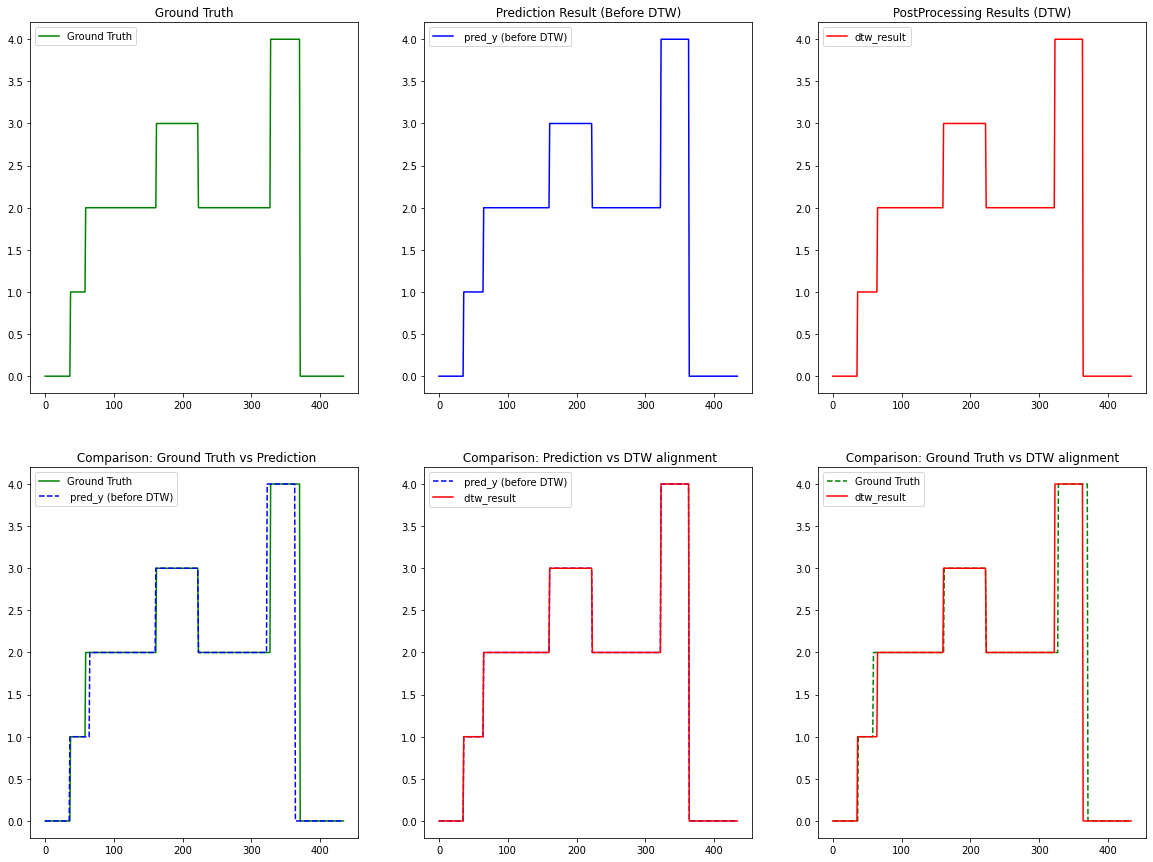

In [15]:
import time 
start = time.time()

save = True


skeleton_csv ="/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/HMM_saveResults_illness_mean/0_sideView/norm20/yjh/04/skeleton_yjh_04.csv"
frameNum, timestamp, pelvis_x, pelvis_y, pelvis_z = utils.get_rawData(skeleton_csv)

pelvis_csv = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/HMM_saveResults_illness_mean/0_sideView/norm20/yjh/04/Originact5_lpf_c0-5o4_labeled_yjh_04.csv"
subname = "yjh"
trial = "04"

saveTrials = MODEL_SAVE_FOLDER_PATH + "/trialResults"
each_saveDir = saveTrials + "/" + subname +"/" + trial
if not os.path.exists(each_saveDir):
    os.makedirs(each_saveDir)
    
# ---- 1-1. create test dataset for model 
test_time, test_x, test_y_onehot = create_testdata(pelvis_csv)   # one-hot encoded (blockSize <- lookback window=8)
test_y = np.argmax(test_y_onehot, axis=1).reshape(-1)   # one-hot decode                    
# ---- 1-2. model prediction 
pred_y_onehot = model.predict(test_x) 
pred_y = np.argmax(pred_y_onehot, axis=1) #  # pred one-hot decode
# ---- 1-3. Post Processing for Final Output (DTW) and 
title = selected_type + "_" + subname + "_" + trial
dtw_alignment, dtw_results = post_process_DTW(test_y,pred_y, answer_y)
        

    
# ---- 2-1. Calc. Accuracy (before DTW vs after DTW) , DTW figure and Analysis texts 
pred_acc , dtw_acc = calc_accuracy(test_y, pred_y, dtw_results, saveDir = each_saveDir, title=title, save=save)
saveDTW_plt(test_y, pred_y, dtw_results,  saveDir = each_saveDir, title = title)
dtw_results = np.array(dtw_results).reshape(-1) 
true_dtw_total_Error_percent, true_dtw_subTask_Error_percent, exceptTrial_check = analysis_timeResults(test_time, test_x, test_y, pelvis_x, pelvis_y, pelvis_z, dtw_results , each_saveDir, title=title, save=save)
                            
#---- Time Check 
print("\nconsuming time:", time.time() - start, " [sec]") # 결과는 초단위 --- 0.54 sec 

In [16]:
# os.rename(MODEL_SAVE_FOLDER_PATH, MODEL_SAVE_FOLDER_PATH + "_loss-" + str(np.round(eval_result[1],4)))
src ="/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" + selected_LPF + expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience) + "-lr:"+ str(learning_rate) + "_" + ModelTime 
dst = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" + selected_LPF +  expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience) + "-lr:"+ str(learning_rate) +"_" + ModelTime + "_loss-" + str(np.round(eval_result[1],4))
print(dst)
os.rename(src, dst)

/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/c3-5o4/HMM_saveResults_illness_mean/class_weight_1/norm60_P50-lr:7e-05_20210521-15h11m_loss-0.9373
